<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Langgraph_with_MessagesState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langchain langgraph langchain-groq tavily-python langchain-community

In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AnyMessage

In [ ]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [ ]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

In [ ]:
def function1(state:MessagesState):
    message=state["messages"]
    print(message)
    print("hello")
    result=llm.invoke(message)
    return {"messages":[result.content]}



In [ ]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",function1)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

In [ ]:
from IPython.display import Image,display

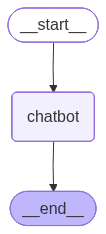

In [ ]:
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
output=app.invoke({"messages":["What is Langgraph in 2 sentences?"]})

[HumanMessage(content='What is Langgraph in 2 sentences?', additional_kwargs={}, response_metadata={}, id='4395a290-d75f-48f2-8644-4314e8aab1fe')]
hello


In [ ]:
response=output["messages"][-1].content
print(response)

LangGraph is a framework that lets developers build and orchestrate language‑model pipelines as directed graphs, where each node represents a processing step and edges encode control flow. By managing state and context across nodes, it enables dynamic, reusable, and testable LLM‑driven applications.


##Adding Tool to our Agent, so that it can use the tools also

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage
from typing import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, MessagesState , add_messages, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode

In [ ]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [ ]:
@tool
def search(query:str):
  """This is the tool that will provide information about weather"""
  if 'nepal' in query.lower() or 'nep' in query.lower() or 'np' in query.lower():
    return "The weather is cold with days warm"
  else:
    return "The weather is extremely cold"

In [ ]:
search.invoke("Nepal weather is?")

'The weather is cold with days warm'

In [ ]:
tools=[search]

In [ ]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
tool_node=ToolNode(tools)

In [ ]:
def function1(state:MessagesState):
  message=state["messages"]
  response=llm_with_tools.invoke(message)
  return {"messages":[response]}



In [ ]:
def router(state:MessagesState)->Literal["tool_node",END]:
  message=state["messages"]
  last_message=message[-1]
  if last_message.tool_calls:
    return "tool_node"
  else:
    return END

In [ ]:
workflow1=StateGraph(MessagesState)
workflow1.add_node("agent",function1)
workflow1.add_node("tool_node",tool_node)
workflow1.add_conditional_edges("agent",router,{"tool_node":"tool_node",END:END})
workflow1.add_edge(START,"agent")
app1=workflow1.compile()

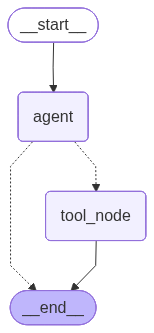

In [ ]:
try:
  display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
app1.invoke({"messages":["Hello"]})

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='99940466-7cb7-41a3-aea8-b650a8d870e8')]
Hello
content='Hello' additional_kwargs={} response_metadata={} id='99940466-7cb7-41a3-aea8-b650a8d870e8'
content='Hello! How can I help you today?' additional_kwargs={'reasoning_content': 'The user says "Hello". Likely a greeting. We should respond politely. Possibly ask what they need.'} response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 129, 'total_tokens': 170, 'completion_time': 0.064686754, 'completion_tokens_details': {'reasoning_tokens': 23}, 'prompt_time': 0.0071797, 'prompt_tokens_details': None, 'queue_time': 0.026078722, 'total_time': 0.071866454}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_84bb35977d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bbb99-fc39-7932-823a-6acc3a3acb4c-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_toke

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='99940466-7cb7-41a3-aea8-b650a8d870e8'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "Hello". Likely a greeting. We should respond politely. Possibly ask what they need.'}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 129, 'total_tokens': 170, 'completion_time': 0.064686754, 'completion_tokens_details': {'reasoning_tokens': 23}, 'prompt_time': 0.0071797, 'prompt_tokens_details': None, 'queue_time': 0.026078722, 'total_time': 0.071866454}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_84bb35977d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bbb99-fc39-7932-823a-6acc3a3acb4c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 129, 'output_tokens': 41, 'total_tokens': 170, 'output_token_details':

In [ ]:
app1.invoke({"messages":["How is the weather in USA?"]})

content='' additional_kwargs={'reasoning_content': 'The user asks: "How is the weather in USA?" They want weather info. We need to use the provided function search with query "weather in USA" or similar. Probably we should call the search function.', 'tool_calls': [{'id': 'fc_0c939e7a-f7f0-4614-9be7-ab7dd12fa5e0', 'function': {'arguments': '{"query":"weather in USA"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 130, 'total_tokens': 198, 'completion_time': 0.079033143, 'completion_tokens_details': {'reasoning_tokens': 44}, 'prompt_time': 0.008412319, 'prompt_tokens_details': None, 'queue_time': 0.508076076, 'total_time': 0.087445462}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bb818-618e-7ab3-8b4c-c46be1131717-0' tool_calls=[{'name': 'search', 'args': {'query': 'we

{'messages': [HumanMessage(content='How is the weather in USA?', additional_kwargs={}, response_metadata={}, id='aad8fb90-4193-42f2-b81d-a4a4b014cd24'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "How is the weather in USA?" They want weather info. We need to use the provided function search with query "weather in USA" or similar. Probably we should call the search function.', 'tool_calls': [{'id': 'fc_0c939e7a-f7f0-4614-9be7-ab7dd12fa5e0', 'function': {'arguments': '{"query":"weather in USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 130, 'total_tokens': 198, 'completion_time': 0.079033143, 'completion_tokens_details': {'reasoning_tokens': 44}, 'prompt_time': 0.008412319, 'prompt_tokens_details': None, 'queue_time': 0.508076076, 'total_time': 0.087445462}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'service_tier': 'on_demand', 'finish_reas

{'messages': [HumanMessage(content='How is the weather in USA?', additional_kwargs={}, response_metadata={}, id='695d05aa-af45-4d65-9b3a-295d272b1371'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "How is the weather in USA?" They want a weather overview. Likely need to use the search function. The tool search can provide info about weather. We can search for "weather in USA".', 'tool_calls': [{'id': 'fc_68d696d7-4473-4468-9f57-d6cb2e72dcf5', 'function': {'arguments': '{"query":"weather in USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 130, 'total_tokens': 199, 'completion_time': 0.094287349, 'completion_tokens_details': {'reasoning_tokens': 45}, 'prompt_time': 0.00822728, 'prompt_tokens_details': None, 'queue_time': 0.451171697, 'total_time': 0.102514629}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_1074f9ce08', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bb814-3144-7dc2-9c9c-a5283be943b1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in USA'}, 'id': 'fc_68d696d7-4473-4468-9f57-d6cb2e72dcf5', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 130, 'output_tokens': 69, 'total_tokens': 199, 'output_token_details': {'reasoning': 45}})]}

## Agent with the tools and cycle between tools and agents

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, MessagesState, START, END , add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from IPython.display import Image, display
from typing import TypedDict, Annotated, Literal

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [ ]:
@tool
def search(query:str):
  """This is the tools that will give the weather report of any country or cities"""
  if 'nepal' in query.lower() or 'np' in query.lower():
    return "The weather is 20 degree celceius at day and 10 degree at night"
  else:
    return "The weather is 25 degree celceius at day and 15 degree at night"


In [ ]:
tools=[search]

In [ ]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
tool_node=ToolNode(tools=tools)

In [ ]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]


In [ ]:
def agent(state:MessagesState):
  message=state["messages"]
  print(message)
  print("final one-----")
  print(message[-1])
  response=llm_with_tools.invoke(message)
  return {"messages":[response]}



In [ ]:
def router(state:MessagesState)->Literal["tool_node",END]:
  message=state["messages"][-1]
  print("From the router")
  print(message)
  ai_message=message.additional_kwargs
  ai_message=ai_message.get("reasoning_content")
  print(ai_message)
  if message.tool_calls:
    return "tool_node"
  else:
    return END

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [ ]:
workflow3=StateGraph(MessagesState)
workflow3.add_node("agent",agent)
workflow3.add_node("tool_node",tool_node)
workflow3.add_conditional_edges("agent",router,{"tool_node":"tool_node",END:END})
workflow3.add_edge(START,"agent")
workflow3.add_edge("tool_node","agent")
app3=workflow3.compile(checkpointer=memory)

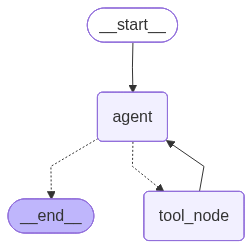

In [ ]:
try:
  display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
config={"configurable":{"thread_id":"3"}}

In [ ]:
while True:
  query=input("Enter your query or else enter break to stop:")
  if query.lower()== "break":
    break
  else:
    events=app3.stream({"messages":[f"{query}"]},config=config,stream_mode="values")
    for event in events:
      event["messages"][-1].pretty_print()



Enter your query or else enter break to stop:helo
================================ Human Message =================================

helo
[HumanMessage(content='helo', additional_kwargs={}, response_metadata={}, id='b14a5c75-d08d-4426-9a31-04e82556f603')]
final one-----
content='helo' additional_kwargs={} response_metadata={} id='b14a5c75-d08d-4426-9a31-04e82556f603'
From the router
content='Hello! 👋 How can I help you today?' additional_kwargs={'reasoning_content': 'User says "helo". Likely greeting. We should respond politely.'} response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 129, 'total_tokens': 164, 'completion_time': 0.040589877, 'completion_tokens_details': {'reasoning_tokens': 15}, 'prompt_time': 0.008287248, 'prompt_tokens_details': None, 'queue_time': 0.110070395, 'total_time': 0.048877125}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_d23c14756c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provid

### Now Creating the agent using class with Tavily search features

In [ ]:
from google.colab import userdata
tavily_api_key=userdata.get('Tavily_api_key')
api_key=userdata.get('groq_api_key')

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage
from typing import Annotated, TypedDict, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph  import START, END, MessagesState, add_messages, StateGraph
from langgraph.prebuilt import ToolNode
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b",api_key=api_key)

In [ ]:
pip install langchain-openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
search_tool=TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    tavily_api_key=tavily_api_key
)

In [ ]:
tools=[search_tool]
llm_with_tools=llm.bind_tools(tools)
tool_node=ToolNode(tools)

In [ ]:
def agent(state:MessagesState):
  message=state["messages"]
  response=llm_with_tools.invoke(message)
  return {"messages":[response]}

In [ ]:
response=agent({"messages":["who is the current prime minister of Nepal?"]})

In [ ]:
print(response)

{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': "We need current prime minister of Nepal. As of 2026? We need up-to-date. Let's search.", 'tool_calls': [{'id': 'fc_1c7243b0-117e-46fb-9858-a990bcf25e89', 'function': {'arguments': '{"query":"current prime minister of Nepal 2026"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 163, 'total_tokens': 221, 'completion_time': 0.070066702, 'completion_tokens_details': {'reasoning_tokens': 24}, 'prompt_time': 0.008039512, 'prompt_tokens_details': None, 'queue_time': 0.002967205, 'total_time': 0.078106214}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_d08f3e4cc0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bbcfc-70a0-7070-8ab9-a1a7360f2a18-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current prime minister

In [ ]:
#adding route function using the toolcalls
def router(state:MessagesState)->Literal["tool_node",END]:
  message=state["messages"]
  last_message=message[-1]
  if last_message.tool_calls:
    return "tool_node"
  else:
    return END


In [ ]:
memory=MemorySaver()
config={"configurable":{"thread_id":"1"}}

In [ ]:
workflow4=StateGraph(MessagesState)
workflow4.add_node("agent",agent)
workflow4.add_node("tavily_tool",tool_node)
workflow4.add_edge(START,"agent")
workflow4.add_conditional_edges(
    "agent",router,{"tool_node":"tavily_tool",END:END}
)
workflow4.add_edge("tavily_tool","agent")
app4=workflow4.compile(checkpointer=memory)

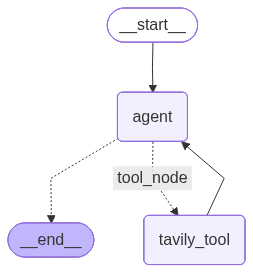

In [ ]:
try:
  display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
while True:
  query=input("Enter your query or else enter exit to stop chat:")
  if query.lower()=="exit":
    break
  else:
    events=app4.stream({"messages":[f"{query}"]},config=config,stream_mode="values")
    for event in events:
      event["messages"][-1].pretty_print()

Enter your query or else enter exit to stop chat:hello
================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! 👋 How can I help you today?
Enter your query or else enter exit to stop chat:who is the current primeminister of Nepal
================================ Human Message =================================

who is the current primeminister of Nepal
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_b64d7eda-3ce4-4a65-92a9-60d63411a13c)
 Call ID: fc_b64d7eda-3ce4-4a65-92a9-60d63411a13c
  Args:
    query: current prime minister of Nepal 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Prime Minister of Nepal - Wikipedia", "url": "https://en.wikipedia.org/wiki/Prime_Minister_of_Nepal", "content": "Prime Minister

### Now our next task is to create a langgraph agent using class so that in the future it will be easy to use it as a utils

### Our new agent will be so powerful that it will use the tavily search tool to get the response


In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, MessagesState, START, END , add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Literal
from langgraph.prebuilt import ToolNode

In [ ]:
@tool
def search_tool(query):
    """This tool uses tavily search"""
    print(query)
    result=self.tool.invoke(query)
    return result

In [ ]:
class Chatbot:
  def __init__(self):
    self.llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)
    self.tavily=TavilySearchResults(
         max_results=5,
        search_depth="advanced",
        tavily_api_key=tavily_api_key)
    @tool
    def search_tool(query:str):
      """This is a tool for tavily search"""
      print(query)
      return self.tavily.invoke(query)
    self.llm_with_tools=self.llm.bind_tools([search_tool])
    self.memory=MemorySaver()
    self.tool_node=ToolNode([search_tool])

  def agent(self,state:MessagesState):
    message=state["messages"]
    response=self.llm_with_tools.invoke(message)
    return {"messages":[response]}

  def route(self,state:MessagesState)->Literal["tool_node","end"]:
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
      return "tool_node"
    else:
      return "end"

  def __call__(self):
    workflow=StateGraph(MessagesState)
    workflow.add_node("agent",self.agent)
    workflow.add_node("tool_node",self.tool_node)
    workflow.add_edge(START,"agent")
    workflow.add_conditional_edges(
        "agent",self.route,{"tool_node":"tool_node","end":END}
    )
    workflow.add_edge("tool_node","agent")
    app=workflow.compile(checkpointer= self.memory)
    return app









In [ ]:
bot = Chatbot()
chat=bot()


In [ ]:
config={"configurable":{"thread_id":"1"}}

In [ ]:
while True:
  query=input("Enter your query or enter exit to quit")
  if query.lower()=="exit":
    break
  else:
    events=chat.stream({"messages":[f"{query}"]},config=config, stream_mode="values")
    for event in events:
      event["messages"][-1].pretty_print()

Enter your query or enter exit to quitwho is pm of india
================================ Human Message =================================

who is pm of india
================================== Ai Message ==================================

The current Prime Minister of India is **Narendra Modi**.  
He has been in office since **26 May 2014**, leading the Bharatiya Janata Party (BJP) and the National Democratic Alliance (NDA) coalition. Modi is the 14th person to hold the office, succeeding Dr. Manmohan Singh.
Enter your query or enter exit to quitexplain the cabinet of him
================================ Human Message =================================

explain the cabinet of him
================================== Ai Message ==================================

## Narendra Modi’s Cabinet – An Overview (as of 2024)

Narendra Modi has led two full terms as India’s Prime Minister (2014‑2024).  The cabinet that he announced after the 2019 general election is the **current 15‑year‑old “Secon

### Now Next Project is to create an ai agents that will automatically decide whether to use RAG or give answer using the llm only

## Step 1 setting all up all the important necessities by installing it

In [2]:
pip install langchain langchain-huggingface langchain-community faiss-cpu langgraph pypdf  langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 5.2 MB/s eta 0:00:00


In [6]:
pip install langchain-core

In [8]:
from langchain_groq import ChatGroq
from langchain_community.vectorstores import FAISS
from langchain_core.messages import SystemMessage
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState,START, END
from typing import Literal
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import PyPDFLoader